In [210]:
%matplotlib ipympl
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import openpyxl 
from scipy.integrate import simps
import adi
import pandas as pd
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from scipy.ndimage import gaussian_filter1d

In [211]:
font_path = 'C:\\Windows\\Fonts\\simsun.ttc'  # 宋體
font_prop = FontProperties(fname=font_path)

npy = 'no' #! 是否儲存npy檔
graph = ['', '', '']   # 是否要畫圖['PPG', 'D1', 'D2']
data = 'Patient'    #要用病患還是正常人資料

if data == 'Patient':
    data_file = 'F:\\Python\\PPG\\All data\\Patient_Signal'
    graph_file = 'F:\\Python\\PPG\\All data\\Patient_Signal\\graph'
elif data == 'Normal':
    data_file = 'F:\\Python\\PPG\\All data\\Normal_Signal'
    graph_file = 'F:\\Python\\PPG\\All data\\Normal_Signal\\graph'

bad_graph = 'F:\\Python\\PPG\\All data\\Bad_Graph'

PPG_path = f'{data_file}\\PPG.csv'
D2_path = f'{data_file}\\D2.csv'

#刪除指定CSV檔
def delete_csv(file):
    if os.path.exists(file):
        os.remove(file)
        print(f'{file}已刪除')
    else:
        print(f'{file}不存在')

delete_csv(PPG_path)
delete_csv(D2_path)

F:\Python\PPG\All data\Patient_Signal\PPG.csv不存在
F:\Python\PPG\All data\Patient_Signal\D2.csv不存在


In [212]:
def butter(DataL, DataR, cut_low, cut_high, sample_rate, order):
    nyqs = sample_rate * 0.5
    H_cut = cut_high / nyqs
    L_cut = cut_low / nyqs
    sos = signal.butter(order, [L_cut, H_cut], analog=False, btype='bandpass', output='sos')
    Filter_Left = signal.sosfiltfilt(sos, DataL)
    Filter_Right = signal.sosfiltfilt(sos, DataR)
    return Filter_Left, Filter_Right

In [213]:
def bassel(DataL, DataR, cut_low, cut_high, sample_rate, order):
    #貝塞爾
    nyqs = sample_rate * 0.5
    H_cut = cut_high / nyqs
    L_cut = cut_low / nyqs
    sos=signal.bessel(order, [L_cut, H_cut] ,  btype='bandpass',  analog=False,  output='sos')
    Filter_Left = signal.sosfiltfilt(sos,  DataL) 
    Filter_Right = signal.sosfiltfilt(sos,  DataR) 

    return Filter_Left, Filter_Right

In [214]:
def find_peak(Filter_Data):
    valley_x, valley_y = find_peaks(Filter_Data * -1, height=0, distance=500)
    cardiac_cycle = np.diff(valley_x)
    peaks_x, peaks_y = find_peaks(Filter_Data, height=0, distance=500)
    peaks_y = peaks_y['peak_heights']
    valley_y = valley_y['peak_heights']
    return peaks_x, peaks_y, valley_x, valley_y, cardiac_cycle

In [215]:
def derivative(Data, Level, values=[]):
    result = np.gradient(Data)

    if Level == 0:
        values.append(Data)
        return 0
    else:
        values.append(Data)
        return derivative(result, Level - 1, values)
    
def process_wave(cycle):
    values = []
    derivative(cycle, 3, values)
    values = np.array(values)
    origin, derivative_1, derivative_2, derivative_3 = values
    derivative_1 = derivative_1 * 50
    derivative_2 = derivative_2 * 5000
    derivative_3 = derivative_3 * 100000

    return [derivative_1, derivative_2, derivative_3]

In [216]:
def Find_Path(path):

    File_path = []

    #find all Data_file path 
    for root,  subfolders,  filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.txt'):
                continue
            filepath = root +'/'+ filename
            new_filepath = filepath.replace("\\", "/")
            File_path.append(new_filepath)

    return File_path

In [217]:
def get_Imformation(path):
    test=path.split('/')
    Name = test[-3]
    State_check = test[-4]
    if State_check =='易堵':
        State = '0'
    else: 
        State = '1'

    file_name = test[len(test)-1]
    name_check = file_name.find('R')
    if name_check != -1:
        hands = 'Right'
    else:
        hands = 'Left'
    
    imformation =[Name, hands, State]

    return imformation, Name

In [218]:
def plot_ppg(waveform, feature, Name, i, hands):
    if graph[0] != 'break':
        x = np.linspace(0, len(waveform), len(waveform))
        plt.figure(figsize=(5, 3))
        plt.plot(waveform, label='PPG')
        plt.plot(x[feature], waveform[feature], 'r.', label='peak')
        plt.title(f'{Name} PPG signal {i} {hands}', fontproperties=font_prop)
        plt.legend()
        plt.grid(True)
        if graph[1] == 'show':
            plt.show()
        elif graph[1] == 'save':
            plt.savefig(f'{graph_file}\\{Name}, {i + 1}th.jpg')

        plt.close('all')

def calculate_PPG(waveform, feature, Name, i, hands):
    peak, B10 = find_peaks(waveform, height=0.3, distance=500)
    if len(peak) < 2:
        return 0, None
    B1 = peak[1]
    B10 = B10['peak_heights'][1]
    B2 = (waveform[feature[5]] + waveform[feature[11]]) / 2
    valley, _ = find_peaks(-waveform, height=-0.3, distance=500)
    if len(valley) < 2:
        return 0, None
    B3 = valley[1] - valley[0]
    y_section = np.abs(waveform[valley[0]:valley[1]+1])
    B5 = np.trapz(y_section, dx=1)
    B6 = peak[1] - peak[0]
    B7 = valley[-1] - peak[-1]
    Delta_T = B2 - B1
    calculate_feature = np.array([B1, B2, B3, B5, B6, B7, B10, Delta_T])
    #print(calculate_feature)
    plot_ppg(waveform, feature, Name, i, hands)

    
    if len(calculate_feature) == 8:
        return 1, calculate_feature
    else:
        return 0, None

def print_features(Name, i, hand, csv_path):
    # Read the CSV file
    data = pd.read_csv(csv_path, header=None)

    # Construct the key from Name, i, and hand to match the first column
    key = f"{Name}, {i}th {hand} d2"

    # Search for the matching row in the first column
    matching_row = data[data[0] == key]

    if not matching_row.empty:
        print(f"Features for {key}:")
        print(matching_row.iloc[0, 1:].values)  # Print feature values (ignoring the first column)
        return matching_row.iloc[0, 1:].values.tolist()
    else:
        print(f"No matching features found for {key}")
        return None

In [219]:
def plot_d1(waveform, Feature, Name, i, hands):
    if graph[1] != 'break':
        x = np.linspace(0, len(waveform), len(waveform))
        plt.figure()
        plt.plot(waveform)
        plt.plot(x[Feature], waveform[Feature], '*', label='Peak')
        plt.title(f'{Name}, {i + 1}th Left_Right',fontproperties=font_prop)
        plt.legend()
        plt.grid()
        if graph[1] == 'show':
            plt.show()
        elif graph[1] == 'save':
            plt.savefig(f'{graph_file}\\{Name}, {i + 1}th d1.jpg')

        plt.close('all')

def calculate_d1(waveform, Name, i, graph, hands):
    
    d1_peaks, B8 = find_peaks(waveform, height=0, distance=800)
    if len(d1_peaks) < 2:
        return 0, None
    B4 = d1_peaks[1] - d1_peaks[0]
    B8 = B8['peak_heights']

    D1_feature = np.array([B4, B8[1]])

    if len(D1_feature) == 2:
        return 1, D1_feature
    else:
        return 0, None

d2

In [220]:
def calculate_d2_feature(waveform, points):
    points_y = np.zeros(6)
    for i in range(6,12):
        points_y[i-6] = waveform[i]
    #print(points_y)
    Ratio_BA = points_y[1] / points_y[0]
    Ratio_CA = points_y[2] / points_y[0]
    Ratio_DA = points_y[3] / points_y[0]
    Ratio_BDCE_A = (points_y[1] - points_y[3] - points_y[2] - points_y[4]) / points_y[0]
    Ratio_CDB_A = (points_y[2] + points_y[3] - points_y[4]) / points_y[0]
    
    features = [Ratio_BA, Ratio_CA, Ratio_DA, Ratio_BDCE_A, Ratio_CDB_A]
    return features


In [221]:
def plot_d2(origin, derivative, Name, i, Feature, hands, locate):
    if graph[2] != 'break':
        x = np.linspace(0, len(derivative[1]), len(derivative[1]))
        plt.figure()
        
        plt.plot(origin)
        plt.plot(derivative[1])
        plt.plot(x[Feature], derivative[1][Feature], '*', label='Peak')
        plt.title(f'{Name}, {i + 1}th {hands}',fontproperties=font_prop)
        plt.legend()
        plt.grid()
        if graph[2] == 'show':
            plt.show()
        else:
            plt.savefig(f'{locate}\\{Name}, {i + 1}th {hands} d2.jpg')
        
        plt.close('all')

def calculate_d2(origin, derivative, Name, i, hands):
    TDPPG_x = np.where(np.diff(np.sign(derivative[2])))[0]
    # 設置最小距離（例如，至少 10 個數據點）
    min_distance = 30

    def filter_by_distance(zero_crossings, min_distance):
        filtered_crossings = []
        last_index = -min_distance  # 初始化為一個遠距離的負數
        
        for index in zero_crossings:
            if index - last_index >= min_distance:
                filtered_crossings.append(index)
                last_index = index
        
        return np.array(filtered_crossings)

    # 過濾零點
    TDPPG_x = filter_by_distance(TDPPG_x, min_distance)

    closest_indices = []

    a_point = np.array(find_peaks(derivative[1], height=0.6, distance=900)[0])


    for num in a_point:
        differences = np.abs(TDPPG_x - num)
        closest_index = np.argmin(differences)
        closest_indices.append(closest_index)
    if len(closest_indices) < 2:  #判斷抓到兩個周期
        plot_d2(origin, derivative, Name, i, TDPPG_x, hands, bad_graph)
        #print(f'{Name}, {i + 1}th {hands} cant find the feature')
        return 0, None, None
    else:
        TDPPG_x_new = TDPPG_x[closest_indices[0]:closest_indices[0]+6]
        TDPPG_x_new = np.append(TDPPG_x_new, TDPPG_x[closest_indices[1]:closest_indices[1]+6])
        if TDPPG_x_new[6] - TDPPG_x_new[5] < TDPPG_x_new[6] * 0.3 or len(TDPPG_x_new) != 12: #判斷是否抓錯feature
            plot_d2(origin, derivative, Name, i, TDPPG_x_new, hands, bad_graph)
            return 0, None, None


    if graph =='show':
        plot_d2(origin,derivative, Name, i, TDPPG_x_new, hands, graph_file)
        print(TDPPG_x_new)
    else:
        D2_feature = calculate_d2_feature(derivative[1], TDPPG_x_new)
        return 1, TDPPG_x_new, D2_feature
    
    return 0, None, None


In [222]:
def WriteCSV(feature, file_path, i, hands, imformation):
    
    # if imformation[2] == '0' and imformation[1] != hands:
    #     change = '1'
    #     new_data = pd.DataFrame([[f"{imformation[0]}"] + [i + 1] + [f"{imformation[1]}"] + [f"{hands}"] + [f"{change}"] + feature.tolist()])
    # else:
    new_data = pd.DataFrame([[f"{imformation[0]}"] + [i + 1] + [f"{imformation[1]}"] + [f"{hands}"] + [f"{imformation[2]}"] + feature.tolist()])

    try:
        # 使用 'utf-8-sig' 編碼，以避免中文亂碼問題
        with open(file_path, 'a', newline='', encoding='utf-8-sig') as f:
            new_data.to_csv(f, index=False, header=False)
    except FileNotFoundError:
        # 如果檔案不存在，直接創建新檔案並寫入
        new_data.to_csv(file_path, index=False, header=False, encoding='utf-8-sig')

In [223]:
def resize_wave(waveform, i, hands, imformation, target_length=2000): # type: ignore
    quilty = 1

    derivative = process_wave(waveform)

    resized = signal.resample(waveform, target_length)
    
    for j in range(3):
        derivative[j] = signal.resample(derivative[j], target_length)
    
    D2_quilty, D2_Point, D2_feature = calculate_d2(resized, derivative, imformation[0], i, hands) # type: ignore
    if D2_quilty == 1:
        D1_quailty, D1_feature = calculate_d1(derivative[0], D2_Point, imformation[0], i, hands)
        quailty, PPG_feature = calculate_PPG(resized, D2_Point, imformation[0], i, hands)
        Classfication_feature = np.hstack((PPG_feature, D1_feature, D2_feature)) # type: ignore
        if D1_quailty == 1 and quailty == 1:
            WriteCSV(D2_Point, D2_path, i, hands, imformation)
            WriteCSV(Classfication_feature, PPG_path, i, hands, imformation)
            
            if npy == 'save':
                np.save(f'{data_file}\\{imformation[0]}, {i + 1}th {hands}.npy', resized)
                np.save(f'{data_file}\\{imformation[0]}, {i + 1}th {hands} d1.npy', derivative[0])
                np.save(f'{data_file}\\{imformation[0]}, {i + 1}th {hands} d2.npy', derivative[1])

    elif npy == 'save':
        np.save(f'{data_file}\\bad signal\\{imformation[0]}, {i + 1}th {hands}.npy', resized)
        np.save(f'{data_file}\\bad signal\\{imformation[0]}, {i + 1}th {hands} d1.npy', derivative[0])
        np.save(f'{data_file}\\bad signal\\{imformation[0]}, {i + 1}th {hands} d2.npy', derivative[1])

In [224]:
def main(): #!for folder data
    channel1_id = 2
    channel2_id = 4
    record_id = 1

    if data == 'Normal':
        File_path = Find_Path("F:\\正常人Data") #!正常人
    elif data == 'Patient':
        File_path = Find_Path("F:\\Python\\PPG\\病患資料") #!病患
    print('找到資料筆數', len(File_path))

    df_c = pd.DataFrame()
    for j, path in tqdm(enumerate(File_path), total=len(File_path), desc='Processing'):
        Data = adi.read_file(path)

        Right = Data.channels[channel1_id - 1].get_data(record_id)
        Left = Data.channels[channel2_id - 1].get_data(record_id)

        Filter_Left,Filter_Right = butter(Left, Right, 0.5, 9, 1000, 4)

        L_wave = Filter_Left[20000:300000] * 10
        R_wave = Filter_Right[20000:300000] * 10

        L_valley_x, L_valley_y = find_peaks(L_wave * -1, height=0, distance=150)
        R_valley_x, R_valley_y = find_peaks(R_wave * -1, height=0, distance=150)

        L_valley_y = L_valley_y['peak_heights']
        R_valley_y = R_valley_y['peak_heights']

        if data == 'Normal':
            imformation,Name = get_Imformation(path) #!正常人
        elif data == 'Patient':
            imformation,Name = get_Imformation(path) #!病患

        if len(L_valley_x) > len(R_valley_x): #找最小的cycle
            min_cycle = len(R_valley_x)
        else:
            min_cycle = len(L_valley_x)
        
        for i in range(0,min_cycle - 2,2):
            L_cycle = L_wave[L_valley_x[i]:L_valley_x[i + 2]] #two cycle

            L_peaks_x, L_peaks_y = find_peaks(L_cycle, height=0, distance=500)
            L_peaks_y = L_peaks_y['peak_heights']

            R_cycle = R_wave[L_valley_x[i]:L_valley_x[i + 2]]

            R_peaks_x, R_peaks_y = find_peaks(R_cycle, height=0, distance=500)
            R_peaks_y = R_peaks_y['peak_heights']

            if len(L_cycle) < 1100 or len(L_peaks_y) != 2 or len(R_peaks_y) != 2 or len(R_cycle) < 1100:
                continue

            if L_peaks_y[0] < 0.5:
                L_cycle *= 0.5 / L_peaks_y[0]
                L_peaks_y[0] = 0.5
                L_peaks_y[1] = 0.5

            if R_peaks_y[0] < 0.5:
                R_cycle *= 0.5 / R_peaks_y[0]
                R_peaks_y[0] = 0.5
                R_peaks_y[1] = 0.5
            resize_wave(L_cycle, i, 'Left', imformation, 2000 )
            resize_wave(R_cycle, i, 'Right', imformation, 2000 )



In [225]:
def analyze_plot(Left, L_cycle):
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(Left)
    plt.title('Original signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(L_cycle)
    plt.title('Cutting cycle')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.tight_layout()
    plt.show()
    

In [ ]:
def analyze_resize_wave(waveform, i, hands, imformation, target_length=2000): # type: ignore
    quilty = 1

    derivative = process_wave(waveform)

    resized = signal.resample(waveform, target_length)
    
    for j in range(3):
        derivative[j] = signal.resample(derivative[j], target_length)
    
    D2_quilty, D2_Point, D2_feature = calculate_d2(resized, derivative, imformation[0], i, hands) # type: ignore

In [227]:
def analyze():
    channel1_id = 2
    channel2_id = 4
    record_id = 1

    File_path = Find_Path("F:\\正常人Data") #!正常人

    print('找到資料筆數', len(File_path))

    df_c = pd.DataFrame()
    for j, path in tqdm(enumerate(File_path), total=len(File_path), desc='Processing'):
        Data = adi.read_file(path)
        imformation,Name = get_Imformation(path)

        Right = Data.channels[channel1_id - 1].get_data(record_id)
        Left = Data.channels[channel2_id - 1].get_data(record_id)

        Filter_Left,Filter_Right = butter(Left, Right, 0.5, 9, 1000, 4)

        L_wave = Filter_Left[20000:300000] * 10
        R_wave = Filter_Right[20000:300000] * 10

        L_valley_x, L_valley_y = find_peaks(L_wave * -1, height=0, distance=150)
        R_valley_x, R_valley_y = find_peaks(R_wave * -1, height=0, distance=150)

        L_valley_y = L_valley_y['peak_heights']
        R_valley_y = R_valley_y['peak_heights']

        if len(L_valley_x) > len(R_valley_x): #找最小的cycle
            min_cycle = len(R_valley_x)
        else:
            min_cycle = len(L_valley_x)
        
        for i in range(0,min_cycle - 2,2):
            diff = np.abs(L_valley_x[i] - R_valley_x[i]) #time diff
            L_cycle = L_wave[L_valley_x[i]:L_valley_x[i + 2]] #two cycle
            L_cycle_cut = [L_wave[L_valley_x[i]:L_valley_x[i + 1]], L_wave[L_valley_x[i + 1]:L_valley_x[i + 2]]] #divide 2

            L_peaks_x, L_peaks_y = find_peaks(L_cycle, height=0, distance=500)
            L_peaks_y = L_peaks_y['peak_heights']
            L_peak = [L_peaks_x, L_peaks_y]

            R_cycle = R_wave[L_valley_x[i]:L_valley_x[i + 2]]
            R_cycle_cut = [R_wave[R_valley_x[i]:R_valley_x[i + 1]], R_wave[R_valley_x[i + 1]:R_valley_x[i + 2]]]  # vivide 2

            R_peaks_x, R_peaks_y = find_peaks(R_cycle, height=0, distance=500)
            R_peaks_y = R_peaks_y['peak_heights']
            R_peak = [R_peaks_x, R_peaks_y]

            if len(L_cycle) < 1100 or len(L_peaks_y) != 2 or len(R_peaks_y) != 2 or len(R_cycle) < 1100:
                continue

            if L_peaks_y[0] < 0.5:
                L_cycle *= 0.5 / L_peaks_y[0]
                L_peaks_y[0] = 0.5
                L_peaks_y[1] = 0.5

            if R_peaks_y[0] < 0.5:
                R_cycle *= 0.5 / R_peaks_y[0]
                R_peaks_y[0] = 0.5
                R_peaks_y[1] = 0.5
            
            if i < 5 and j == 5:
                analyze_plot(Right, Filter_Right)
                analyze_plot(Right, R_cycle)
                analyze_resize_wave(R_cycle, i, 'Right', imformation, 2000)

        

找到資料筆數 63


Processing:   5%|▍         | 3/63 [00:00<00:02, 29.05it/s]

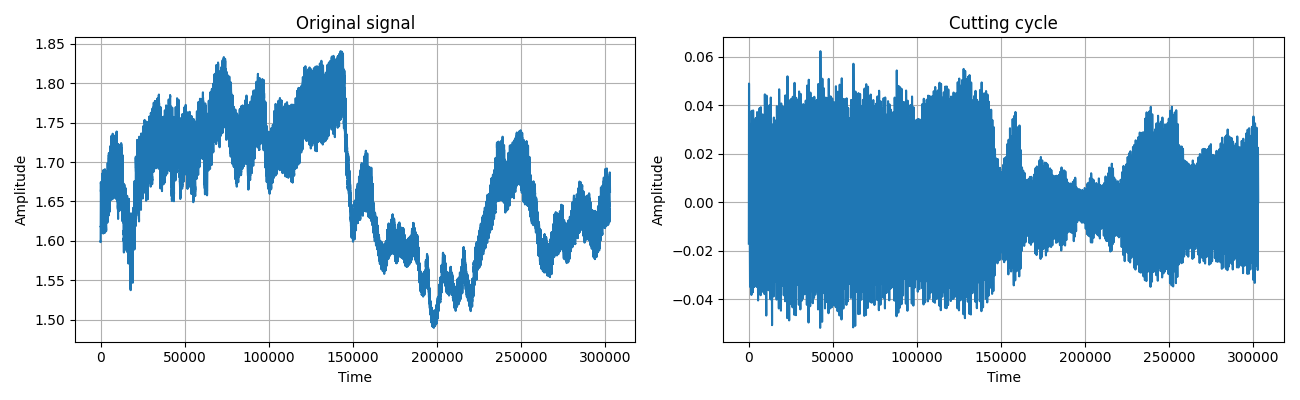

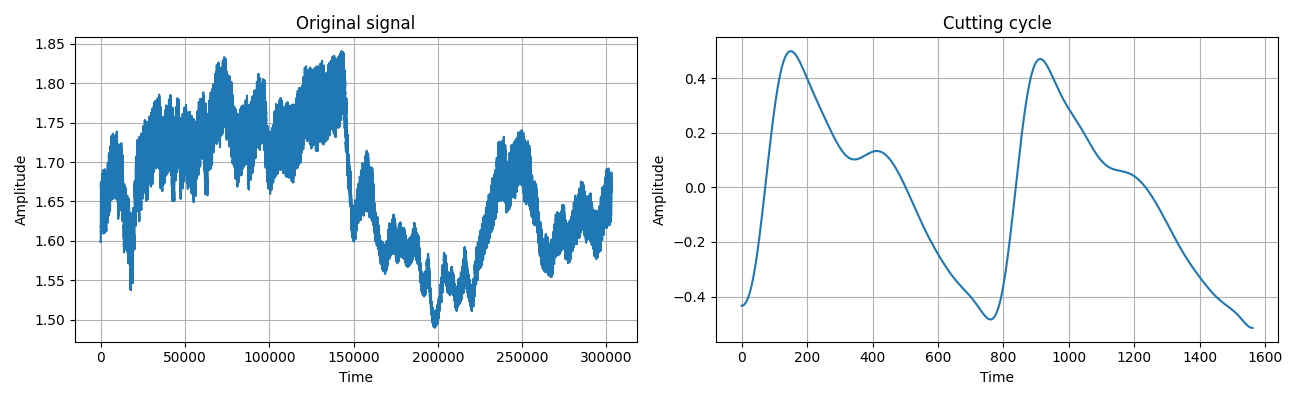

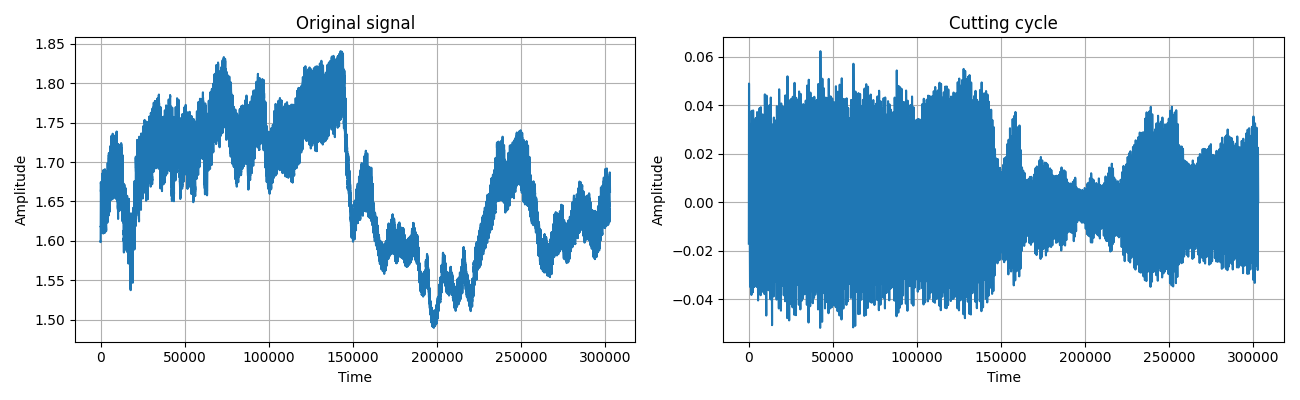

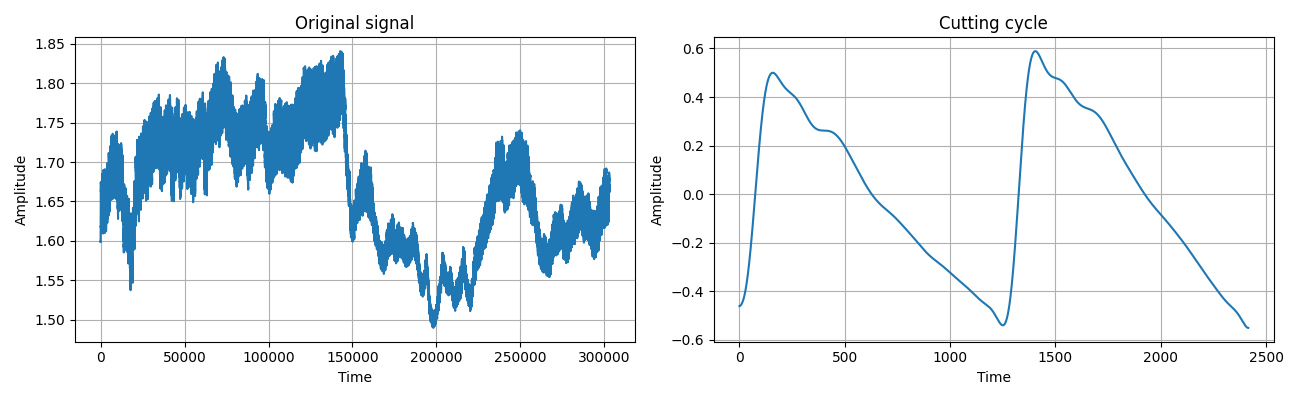

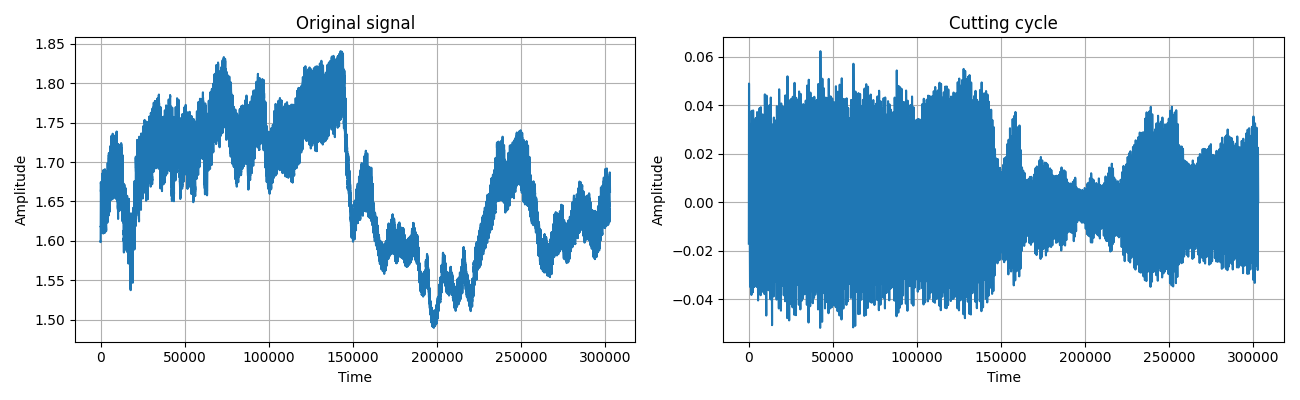

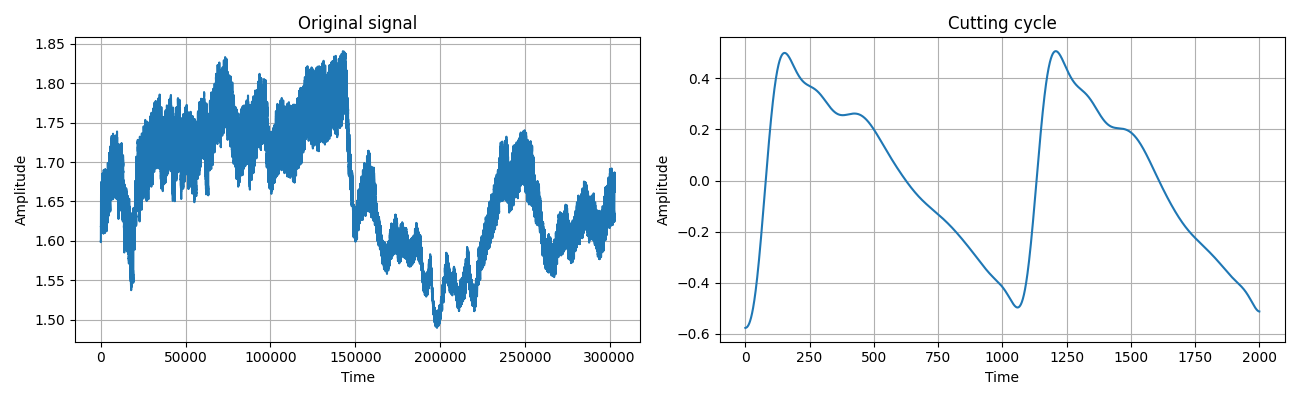

Processing: 100%|██████████| 63/63 [00:03<00:00, 16.35it/s]


In [228]:
if __name__ == '__main__':
    analyze()
    #main()